# Build offshore bathymetry suitability layers for GRIDCERF


The following code was used to build the offshore bathymetry suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  General Bathymetric Chart of the Oceans - Global ocean & land terrain models
- **Description from Source**: GEBCO’s current gridded bathymetric data set, the GEBCO_2023 Grid, is a global terrain model for ocean and land, providing elevation data, in meters, on a 15 arc-second interval grid. It is accompanied by a Type Identifier (TID) Grid that gives information on the types of source data that the GEBCO_2023 Grid is based on.
- **Source URL**:  https://www.gebco.net/data_and_products/gridded_bathymetry_data/#area
- **Date Accessed**:  4/17/24
- **Citation**
> GEBCO. Global ocean & land terrain models. General Bathymetric Chart of the Oceans. British Oceanographic Data Centre. https://www.gebco.net/data_and_products/gridded_bathymetry_data/#area (2024).
- **Application**:
Gridded data is downloaded from the GEBCO data source with the following extent: North 53.4349, South 15.5272, West -135.7826, East -61.7518. Data is then projected to the albers equal area conic crs (ESRI:102003). Offshore wind is not capable of being sited in waters of depth greater than -1300m (https://www.nrel.gov/docs/fy22osti/83650.pdf). All areas of greater depth are given a value of 1 (excluded). This data file includes both oceanic and great lakes areas.

### 1.3 Import modules


In [1]:
import os

import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features
from rasterio.plot import show

## 2. Configuration


In [27]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded airport data
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'offshore_bathymetry' )

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# raster location for the source data
bathymetry_path = os.path.join(source_dir, "gebco_2023_n53.4349_s15.5272_w-135.7826_e-61.7518.tif")

# output rasters
output_raster_file = os.path.join(technology_specific_dir, "gridcerf_gebco_offshore_bathymetry_greater_than_1300m.tif")

# crs for converting projections
crs = 'ESRI:102003'

# set maximum water depth
maximum_depth = -1300

## 4. Generate suitability rasters

### 4.1 Translate geospatial raster to albers crs and correct extent

In [ ]:
tmp_output = os.path.join(source_dir, 'tmp.tif')

# gdal warp command
gdal_cmd = f'gdalwarp -s_srs EPSG:4326 -t_srs ESRI:102003 -tr 1000.0 1000.0 -r bilinear -te -2831615.228 -1539013.3223 2628318.0948 1690434.1707 -te_srs ESRI:102003 -of GTiff {bathymetry_path} {tmp_output}'

os.system(gdal_cmd)

### 4.2 Generate suitability

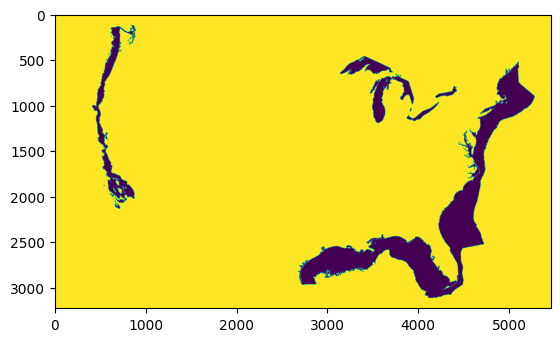

In [29]:
# create suitable raster
with rasterio.open(template_raster) as src:
    
    # update metadata datatype to int16
    metadata = src.meta.copy()

    siting_mask = src.read(1)
    siting_mask = np.where(siting_mask == 0, 1, 0)
    with rasterio.open(tmp_output) as bath_tif:
        
        arr = bath_tif.read(1)

        # make all areas with seafloor deeper than 1000m below water unsuitable
        arr = np.where(arr < maximum_depth, 1, 0)
        
        # apply siting mask
        arr += siting_mask.astype('int64')
        arr = np.where(arr >= 1, 1, 0).astype(np.float64)
        
        # make nan excluded
        arr = np.where(np.isnan(arr), 1, arr)

        with rasterio.open(land_mask_raster) as land_tif:
            land_array = land_tif.read(1)
            land_array = np.where(land_array==0, 1, 2)
            
            # apply land area mask
            arr += land_array
            arr = np.where(arr ==2, 1, 0)

            show(arr)
        with rasterio.open(output_raster_file, 'w', **metadata) as dest:
            dest.write(arr.astype(rasterio.int16), 1)
